##Trabalho Final IAA015

###Participantes:

* Adilson Krischanski
* Ana de Vasconcellos Oporto
* Pedro Augusto Pereira H. dos Santos
* Renan Belem Biavati
* Saulo Roberto da Silva

#1) Algoritmo Genético

In [1]:
!pip install numpy matplotlib


✅ 100 Cidades geradas aleatoriamente no espaço 100x100.

--- Início do AG ---
População inicial: 100 indivíduos.
Melhor distância inicial (Geração 0): 4526.13
Geração  100: Melhor Distância = 1979.46
Geração  200: Melhor Distância = 1806.35
Geração  300: Melhor Distância = 1564.16
Geração  400: Melhor Distância = 1498.64
Geração  500: Melhor Distância = 1454.87
Geração  600: Melhor Distância = 1409.26
Geração  700: Melhor Distância = 1402.09
Geração  800: Melhor Distância = 1391.71
Geração  900: Melhor Distância = 1390.05
Geração 1000: Melhor Distância = 1371.11
--- Fim do AG ---

         RELATÓRIO FINAL DO ALGORITMO GENÉTICO
Tempo de Execução Total: 243.84 segundos
Número de Gerações: 1000
Tamanho da População: 100 indivíduos
Taxa de Cruzamento (OX): 90%
Taxa de Mutação (Swap): 1%
--------------------------------------------------
**Melhor Solução Inicial (Geração 0):**
   Distância: 4526.13
--------------------------------------------------
**Melhor Solução Final (Geração 1000):**


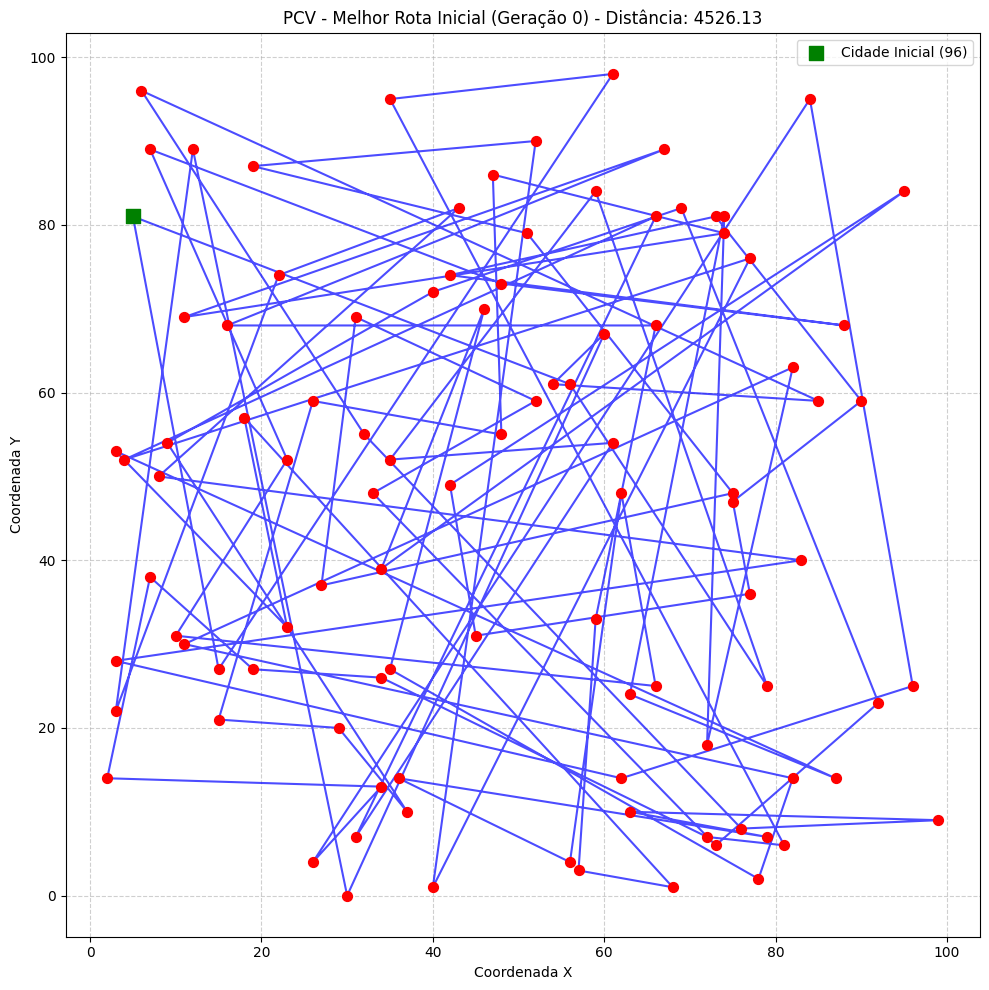

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

#FUNÇÕES DE SUPORTE E GERAÇÃO INICIAL

def generate_cities(num_cities, map_limit=100):
    """Gera coordenadas aleatórias para as cidades dentro do limite do mapa."""
    # Garante que as coordenadas sejam únicas
    cities = set()
    while len(cities) < num_cities:
        x = random.randint(0, map_limit)
        y = random.randint(0, map_limit)
        cities.add((x, y))

    # Converte o set de volta para lista e adiciona o índice (id da cidade)
    cities_list = list(cities)
    return cities_list

def distance(city1, city2):
    """Calcula a distância euclidiana entre duas cidades (pontos)."""
    # Minimizar a distância euclidiana
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def calculate_route_distance(route, cities_data):
    """Calcula a distância total de uma rota, incluindo o retorno ao início."""
    total_distance = 0
    # A rota inclui a cidade de início no final (ex: [0, 5, 2, 0])
    for i in range(len(route) - 1):
        city_id_a = route[i]
        city_id_b = route[i+1]

        # city_data é uma lista de coordenadas
        coord_a = cities_data[city_id_a]
        coord_b = cities_data[city_id_b]

        total_distance += distance(coord_a, coord_b)
    return total_distance

def create_initial_population(num_individuals, num_cities, start_city_id=0):
    """Cria a população inicial de rotas."""
    population = []

    # As 99 cidades intermediárias que precisam ser permutadas
    intermediate_cities = list(range(num_cities))
    intermediate_cities.pop(start_city_id)

    for _ in range(num_individuals):
        # Gera uma permutação aleatória das cidades intermediárias
        random.shuffle(intermediate_cities)

        # O cromossomo tem 101 posições (100 cidades + volta)
        route = [start_city_id] + intermediate_cities + [start_city_id]
        population.append(route)

    # Utiliza no mínimo uma população com 100 indivíduos
    return population

# OPERADORES GENÉTICOS

def order_crossover(parent1, parent2):
    """
    Operador Order Crossover (OX) para PCV.
    Cria um filho a partir de dois pais, preservando a ordem relativa.
    """
    # Ignora o ponto inicial/final para o crossover, foca nas 99 cidades intermediárias
    p1 = parent1[1:-1]
    p2 = parent2[1:-1]
    size = len(p1)

    # Escolhe dois pontos de corte aleatórios
    start, end = sorted(random.sample(range(size), 2))

    # Copia o segmento central do Pai 1
    child_segment = p1[start:end]
    child = [None] * size
    child[start:end] = child_segment

    # Preenche o restante do filho na ordem do Pai 2 pulando as cidades já presentes no segmento do Pai 1

    # Cidades já no filho
    cities_in_child = set(child_segment)

    # Índices do filho a serem preenchidos (cíclico a partir do ponto end)
    child_indices = list(range(end, size)) + list(range(start))

    # Ponteiro para o Pai 2
    p2_idx = 0

    for c_idx in child_indices:
        # Encontra a próxima cidade válida no Pai 2
        while p2[p2_idx] in cities_in_child:
            p2_idx += 1

        child[c_idx] = p2[p2_idx]
        p2_idx += 1

    # Adiciona a cidade de início/fim de volta
    start_city = parent1[0]
    return [start_city] + child + [start_city]

def swap_mutation(route):
    """
    Operador de Troca (Swap) para Mutação.
    Troca a posição de duas cidades aleatórias no segmento intermediário.
    """
    mutated_route = route[1:-1].copy()
    size = len(mutated_route)

    # Escolhe duas posições diferentes para troca
    idx1, idx2 = random.sample(range(size), 2)

    # Realiza a troca
    mutated_route[idx1], mutated_route[idx2] = mutated_route[idx2], mutated_route[idx1]

    # Reconstrói a rota completa
    start_city = route[0]
    return [start_city] + mutated_route + [start_city]

def tournament_selection(population, cities_data, k=5):
    """Seleção por Torneio: Escolhe o indivíduo com o melhor fitness de K indivíduos."""
    # O fitness é o inverso da distância (minimizar distância = maximizar fitness)
    best_route = None
    best_fitness = -1.0

    # Escolhe K competidores aleatórios
    competitors = random.sample(population, k)

    for route in competitors:
        distance = calculate_route_distance(route, cities_data)
        # Fitness = 1 / Distância (para maximização)
        fitness = 1.0 / distance

        if fitness > best_fitness:
            best_fitness = fitness
            best_route = route

    return best_route

# ALGORITMO GENÉTICO PRINCIPAL

def genetic_algorithm_tsp(cities_data, generations=1000, pop_size=100,
                          crossover_rate=0.90, mutation_rate=0.01):

    num_cities = len(cities_data)

    # Define a cidade de início aleatoriamente
    start_city_id = random.randint(0, num_cities - 1)

    # Geração da População Inicial
    population = create_initial_population(pop_size, num_cities, start_city_id)

    # Avaliação da população inicial
    distances = [calculate_route_distance(route, cities_data) for route in population]

    # Encontra a melhor solução inicial
    best_initial_distance = min(distances)
    best_initial_route = population[distances.index(best_initial_distance)]

    # Estruturas para rastrear a evolução
    best_distance_history = [best_initial_distance]
    current_best_route = best_initial_route
    current_best_distance = best_initial_distance

    # Rastrear a melhor solução geral (Elitismo)
    elite_route = best_initial_route

    print(f"--- Início do AG ---")
    print(f"População inicial: {pop_size} indivíduos.")
    print(f"Melhor distância inicial (Geração 0): {best_initial_distance:.2f}")

    # Loop principal do AG (mínimo de 1000 gerações)
    for gen in range(1, generations + 1):
        new_population = []

        # Preserva sempre a melhor solução (Elitismo)
        new_population.append(elite_route)

        # Quantidade de indivíduos por operador, 90% por cruzamento (arredondado para garantir o tamanho da pop)
        num_crossover = int(pop_size * crossover_rate)

        # 1% por mutação (após o elitismo)
        num_mutation = int(pop_size * mutation_rate)

        # O restante será gerado por Crossover + Mutação ou cópia
        # Ajusta para que a soma de todos os novos indivíduos + o elite seja pop_size
        num_crossover = pop_size - 1 - num_mutation
        if num_crossover < 0:
             num_crossover = pop_size - 1 # Se a mutação for maior que 99, prioriza o cruzamento

        # Crossover
        for _ in range(num_crossover):
            # Seleciona dois pais
            parent1 = tournament_selection(population, cities_data)
            parent2 = tournament_selection(population, cities_data)

            # Aplica o Order Crossover (OX)
            child = order_crossover(parent1, parent2)
            new_population.append(child)

        # Mutação, indivíduos aleatórios da população atual
        for _ in range(num_mutation):
            # Seleciona um indivíduo aleatório
            individual_to_mutate = random.choice(population)

            # Aplica a Mutação Swap
            mutated_individual = swap_mutation(individual_to_mutate)
            new_population.append(mutated_individual)

        # Atualiza a população
        population = new_population

        # Avalia a nova população para encontrar o novo elite
        distances = [calculate_route_distance(route, cities_data) for route in population]
        current_best_distance = min(distances)
        current_best_route = population[distances.index(current_best_distance)]

        # Atualiza o elite
        if current_best_distance < calculate_route_distance(elite_route, cities_data):
            elite_route = current_best_route

        # Armazena o melhor resultado da geração para o histórico
        best_distance_history.append(current_best_distance)

        # Relatório de progresso
        if gen % 100 == 0 or gen == generations:
            print(f"Geração {gen:4d}: Melhor Distância = {current_best_distance:.2f}")

    print(f"--- Fim do AG ---")

    return best_initial_route, best_initial_distance, elite_route, current_best_distance

# FUNÇÃO DE VISUALIZAÇÃO E EXECUÇÃO

def plot_tsp_route(cities_data, route, title, filename):
    """Gera o plot 2D das cidades e da rota."""

    # Extrai as coordenadas X e Y
    x_coords = [c[0] for c in cities_data]
    y_coords = [c[1] for c in cities_data]

    # Prepara as coordenadas da rota (usa os IDs da rota)
    route_x = [cities_data[i][0] for i in route]
    route_y = [cities_data[i][1] for i in route]

    plt.figure(figsize=(10, 10))

    # Plota o caminho (linha)
    plt.plot(route_x, route_y, marker='o', linestyle='-', color='blue', alpha=0.7)

    # Plota todas as cidades (pontos)
    plt.scatter(x_coords, y_coords, color='red', s=50, zorder=5)

    # O f-string pega o ID real da cidade que está na posição 0 da rota
    plt.scatter(x_coords[route[0]], y_coords[route[0]], color='green', marker='s', s=100, label=f'Cidade Inicial ({route[0]})', zorder=6)

    plt.title(title)
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()

    # Salva a imagem
    plt.savefig(f'{filename}.png')
    plt.show()

# EXECUÇÃO DO TRABALHO
# Parâmetros conforme os requisitos
NUM_CITIES = 100
GENERATIONS = 1000
POPULATION_SIZE = 100
CROSSOVER_RATE = 0.90
MUTATION_RATE = 0.01

# Geração das Cidades
cities_coords = generate_cities(NUM_CITIES)
print(f"\n✅ 100 Cidades geradas aleatoriamente no espaço 100x100.\n")

# Execução do Algoritmo Genético
start_time = time.time()
best_initial_route, best_initial_dist, best_final_route, best_final_dist = genetic_algorithm_tsp(
    cities_coords,
    generations=GENERATIONS,
    pop_size=POPULATION_SIZE,
    crossover_rate=CROSSOVER_RATE,
    mutation_rate=MUTATION_RATE
)
end_time = time.time()

# Geração do Relatório
print("\n" + "="*50)
print("         RELATÓRIO FINAL DO ALGORITMO GENÉTICO")
print("="*50)
print(f"Tempo de Execução Total: {end_time - start_time:.2f} segundos")
print(f"Número de Gerações: {GENERATIONS}")
print(f"Tamanho da População: {POPULATION_SIZE} indivíduos")
print(f"Taxa de Cruzamento (OX): {CROSSOVER_RATE*100:.0f}%")
print(f"Taxa de Mutação (Swap): {MUTATION_RATE*100:.0f}%")
print("-" * 50)
print(f"**Melhor Solução Inicial (Geração 0):**")
print(f"   Distância: {best_initial_dist:.2f}")
# print(f"   Rota: {best_initial_route}")
print("-" * 50)
print(f"**Melhor Solução Final (Geração {GENERATIONS}):**")
print(f"   Distância: {best_final_dist:.2f}")
# print(f"   Rota: {best_final_route}")
print("-" * 50)
print(f"**Melhoria:** {(1 - best_final_dist / best_initial_dist) * 100:.2f}%")
print("="*50)

#Geração das Imagens
# img 1
plot_tsp_route(
    cities_coords,
    best_initial_route,
    f'PCV - Melhor Rota Inicial (Geração 0) - Distância: {best_initial_dist:.2f}',
    'tsp_initial_route'
)

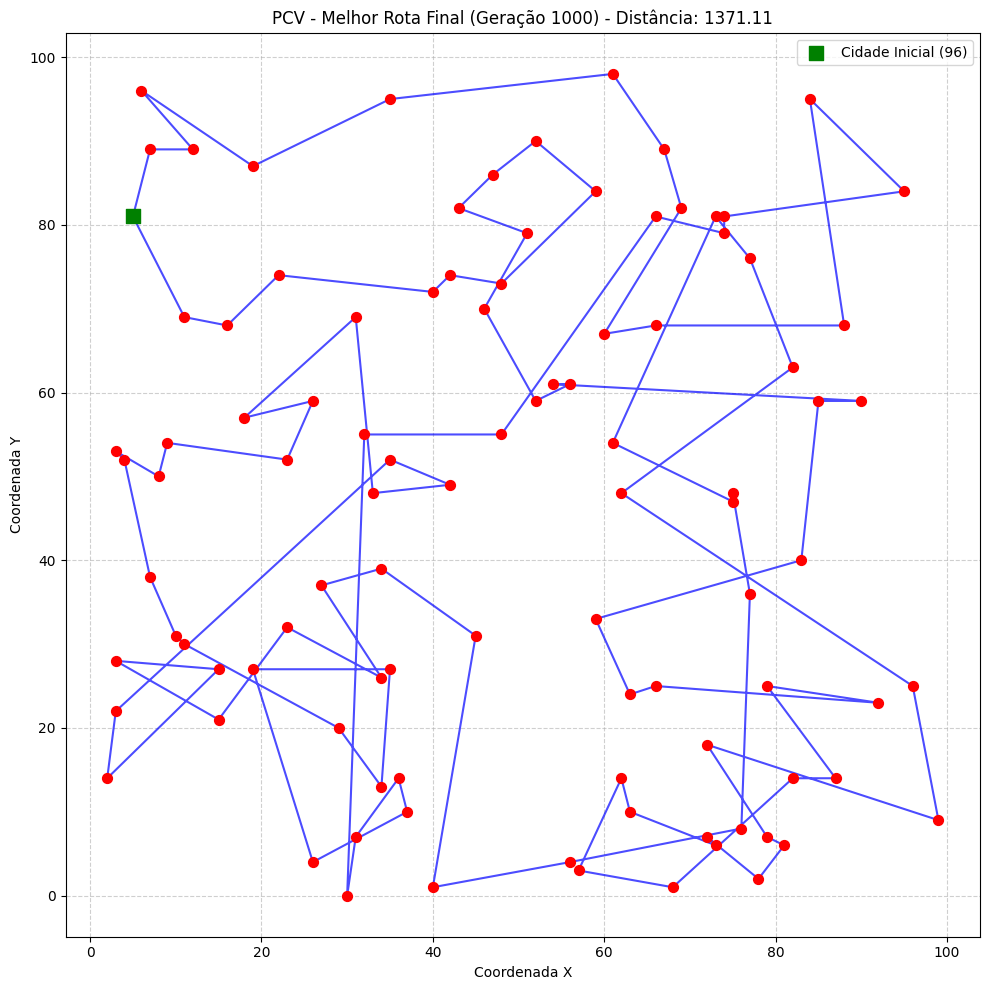

In [3]:
# img 2
plot_tsp_route(
    cities_coords,
    best_final_route,
    f'PCV - Melhor Rota Final (Geração {GENERATIONS}) - Distância: {best_final_dist:.2f}',
    'tsp_final_route'
)

#2) Compare a representação de dois modelos vetoriais

In [4]:
!pip install scikit-learn numpy pandas matplotlib sentence-transformers

Total de textos para vetorização: 6

--- Processando com TF-IDF ---
Dimensionalidade dos vetores TF-IDF: (6, 36)


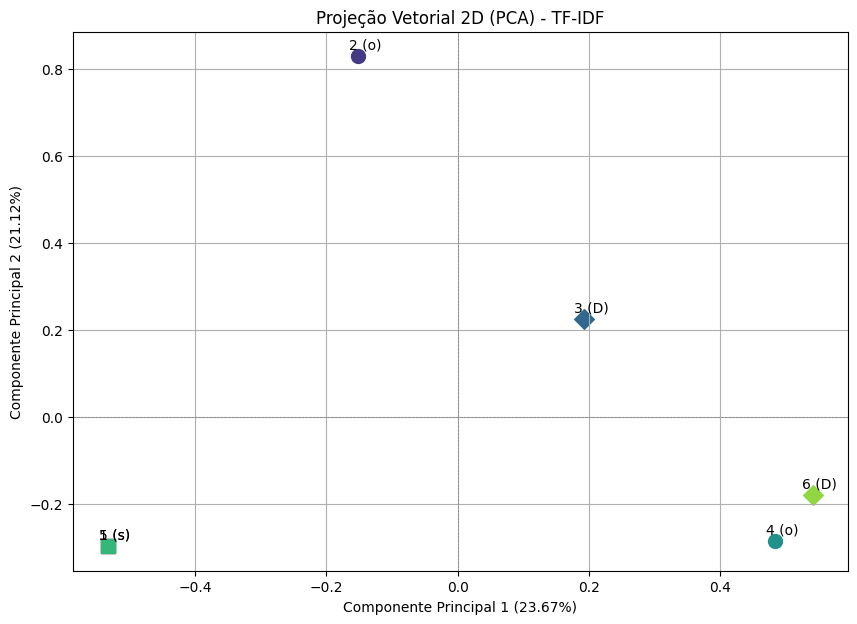

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# Dados de Texto
# Observação: As sentenças 1 e 5 são semanticamente similares; 3 e 6 também.
textos = [
    "O gato preto dormiu tranquilamente na caixa.", # 1 (Similar a 5)
    "A inteligência artificial não vai dominar o mundo.", # 2
    "Eu adoro comer pizza e beber refrigerante.", # 3 (Similar a 6)
    "A lua cheia iluminou o céu estrelado de noite.", # 4
    "O felino escuro repousou com calmaria na cama.", # 5 (Similar a 1)
    "Gosto muito de saborear uma fatia de pizza.", # 6 (Similar a 3)
]

print(f"Total de textos para vetorização: {len(textos)}")

# Funções de Processamento

def aplicar_pca_e_plotar(vetores, nomes, titulo):
    """Aplica PCA e plota os vetores em um gráfico 2D."""

    # Reduzir a dimensionalidade para 2 componentes principais
    # Se a dimensionalidade original for < 2, a PCA é ajustada para a dimensao original
    n_components = min(vetores.shape[1], 2)
    pca = PCA(n_components=n_components, random_state=42)
    vetores_pca = pca.fit_transform(vetores)

    # Criar DataFrame para facilitar o plot
    df = pd.DataFrame(vetores_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    df['Texto'] = nomes

    plt.figure(figsize=(10, 7))

    # Plotar os pontos
    scatter = plt.scatter(df['PC1'], df['PC2'], c=range(len(df)), cmap='viridis')

    # Adicionar anotações para cada ponto
    for i, txt in enumerate(df['Texto']):
        # Destacar os textos similares com um marcador diferente
        marker = 'o'
        if i in [0, 4]: # Texto 1 e 5
            marker = 's' # Quadrado
        elif i in [2, 5]: # Texto 3 e 6
            marker = 'D' # Diamante

        plt.annotate(
            f"{i+1} ({marker})",
            (df['PC1'][i], df['PC2'][i]),
            textcoords="offset points",
            xytext=(5, 5),
            ha='center'
        )
        # Re-plotar com o marcador de destaque
        plt.scatter(df['PC1'][i], df['PC2'][i], marker=marker, color=plt.cm.viridis(i/len(df)), s=100)

    plt.title(f'Projeção Vetorial 2D (PCA) - {titulo}')
    plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.grid(True)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.show()

# Codificação e Visualização

### Modelo Vetorial 1: TF-IDF (Term Frequency-Inverse Document Frequency)
print("\n--- Processando com TF-IDF ---")
vectorizer_tfidf = TfidfVectorizer()
vetores_tfidf = vectorizer_tfidf.fit_transform(textos).toarray()
print(f"Dimensionalidade dos vetores TF-IDF: {vetores_tfidf.shape}")

aplicar_pca_e_plotar(vetores_tfidf, textos, "TF-IDF")


--- Processando com Sentence-BERT ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Dimensionalidade dos vetores S-BERT: (6, 384)


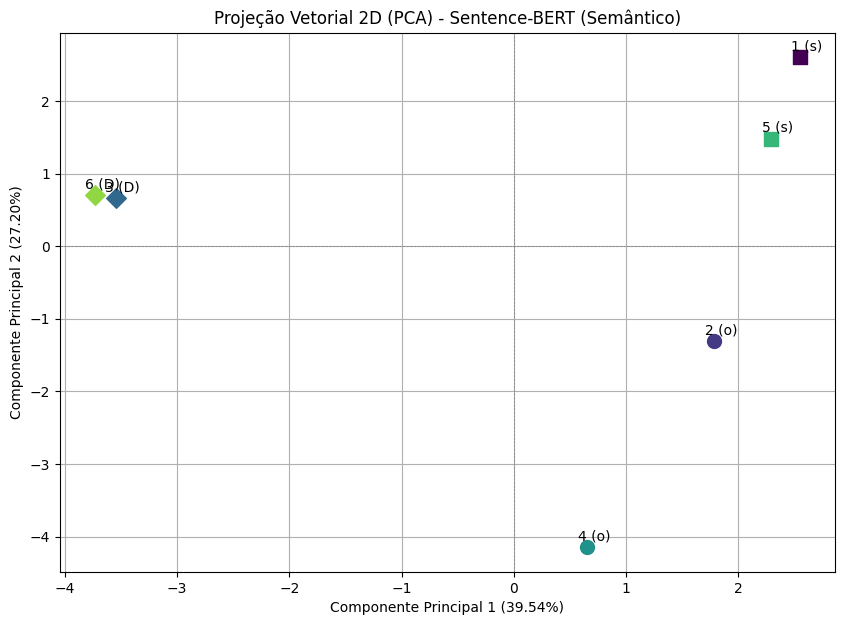

In [6]:
### Modelo Vetorial 2: Sentence-BERT (Embeddings Semânticos)
print("\n--- Processando com Sentence-BERT ---")
# Usando um modelo multilíngue que entende português
model_sbert = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
vetores_sbert = model_sbert.encode(textos, convert_to_numpy=True)
print(f"Dimensionalidade dos vetores S-BERT: {vetores_sbert.shape}")

aplicar_pca_e_plotar(vetores_sbert, textos, "Sentence-BERT (Semântico)")